<a href="https://colab.research.google.com/github/soumyadoddagoudar/SchoolofAI_EVA2.0/blob/master/Assignment6b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment6B
Improve network accuracy- Trying out different types of convolution layers,  Idea is to understand Inception models, and keras Functional API

References- 

Depthwise separable convolution - https://keras.io/layers/convolutional/ keras.layers.SeparableConv2D


Functonal API- https://keras.io/getting-started/functional-api-guide/


##Load libraries, data and prepare data to train model

In [0]:
#Import libraries

from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout,GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

from keras.regularizers import l2
from keras.layers import Input, SeparableConv2D, Conv1D, Conv2D
from keras.layers import Concatenate

Data set - CIFAR 10 It has 10 classes, Each image have size 32X32. Train data has 50k images and test has 10k images.

In [20]:
#Import data
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))
print(train_features.shape)
print(test_features.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


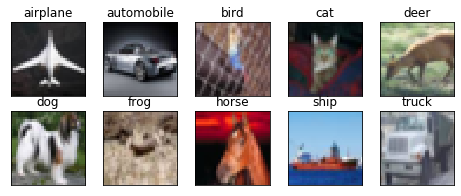

In [21]:
#plot some train examples
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:

#function to plot graph of training
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
#Accuracy function 
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
#Normalize data
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

##Implementing different types of convolution layers
Steps defined for assignment are
1.	Normal Convolution
2.	Spatially Separable Convolution  (Conv2d(x, (3,1)) followed by Conv2D(x,(1,3))
3.	Depthwise Separable Convolution- keras.layers.SeparableConv2D
4.	Grouped Convolution (use 3x3, 5x5 only)
5.	Grouped Convolution (use 3x3 only, one with dilation = 1, and another with dilation = 2) 
6.	You must use all of the 5 above at least once
7.	Train this new model for 50 epochs. 
8.	Save File as Assignment 6B


###Redefining Model  



1.   Input size is specified for model(32,32,3). Started model from normal convolution layer, then grouped conv of spatially separable and depthwise separable.
2.   concatenated result of above layers is fed to maxpool layer follwed by goruped conv of 3X3 and 5X5.

3.   Finally GlobalAveragePool is used followed by softmax.

**Accuracy obtained is : 88.04%**





In [0]:

import keras
input_ = Input(shape = (32,32,3))

# Define the model

#normal convolutions
conv1 = Conv2D(48,(3,3),padding = 'same')(input_)
bn1 = BatchNormalization()(conv1)
relu1 = Activation('relu')(bn1)
do1 = Dropout(0.1)(relu1)

#spatially  separable
conv2 = Conv2D(64, (3,1), padding = 'same')(do1)
conv3 = Conv2D(64, (1,3), padding = 'same')(conv2)
bn2 = BatchNormalization()(conv3)
relu2 = Activation('relu')(bn2)
do2 = Dropout(0.05)(relu2)

#Depthwise separable
conv4 = SeparableConv2D(64,(3,3),padding = 'same')(do1)
bn4 = BatchNormalization()(conv4)
relu4 = Activation('relu')(bn4)
do4 = Dropout(0.05)(relu4)


#concat depth wise and spatially separable outputs
concat1 = Concatenate(axis = 3)([do2,do4])

mp1 = MaxPooling2D(2,2)(concat1)


#grouped convolution-3X3,5X5
conv5=Convolution2D(192,(3,3),padding='same')(mp1)
bn5=BatchNormalization()(conv5)
relu5=Activation('relu')(bn5)
do5=Dropout(0.1)(relu5)


conv5_=Convolution2D(192,(5,5),padding='same')(mp1)
bn5_=BatchNormalization()(conv5_)
relu5_=Activation('relu')(bn5_)
do5_=Dropout(0.1)(relu5_)

#Concat (3,3) and (5,5) convolutions.
concat2 = Concatenate(axis = 3)([do5,do5_])

mp2 = MaxPooling2D(2,2)(concat2)


#Grouped Convolution (use 3x3 only, one with dilation = 1, and another with dilation = 2)
conv6=Convolution2D(96,(3,3),padding='same',dilation_rate=1)(mp2)
bn6=BatchNormalization()(conv6)
relu6=Activation('relu')(bn6)
do6=Dropout(0.1)(relu6)

conv6_=Convolution2D(96,(3,3),padding='same',dilation_rate=2)(mp2)
bn6_=BatchNormalization()(conv6_)
relu6_=Activation('relu')(bn6_)
do6_=Dropout(0.1)(relu6_)

concat3= Concatenate(axis=3)([do6, do6_])


conv7 = Conv2D(48,(3,3),padding = 'same')(concat3)
bn7 = BatchNormalization()(conv7)
relu7 = Activation('relu')(bn7)
do7 = Dropout(0.1)(relu7)

conv8=Convolution2D(10, 1,padding='same')(do7)





gap1 = GlobalAveragePooling2D()(conv8)
softmax = Activation('softmax')(gap1)

model = keras.Model(inputs = input_, outputs = softmax)


                     
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 32, 32, 48)   1344        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 32, 32, 48)   192         conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 32, 32, 48)   0           batch_normalization_17[0][0]     
____________________________________________________________________________________________

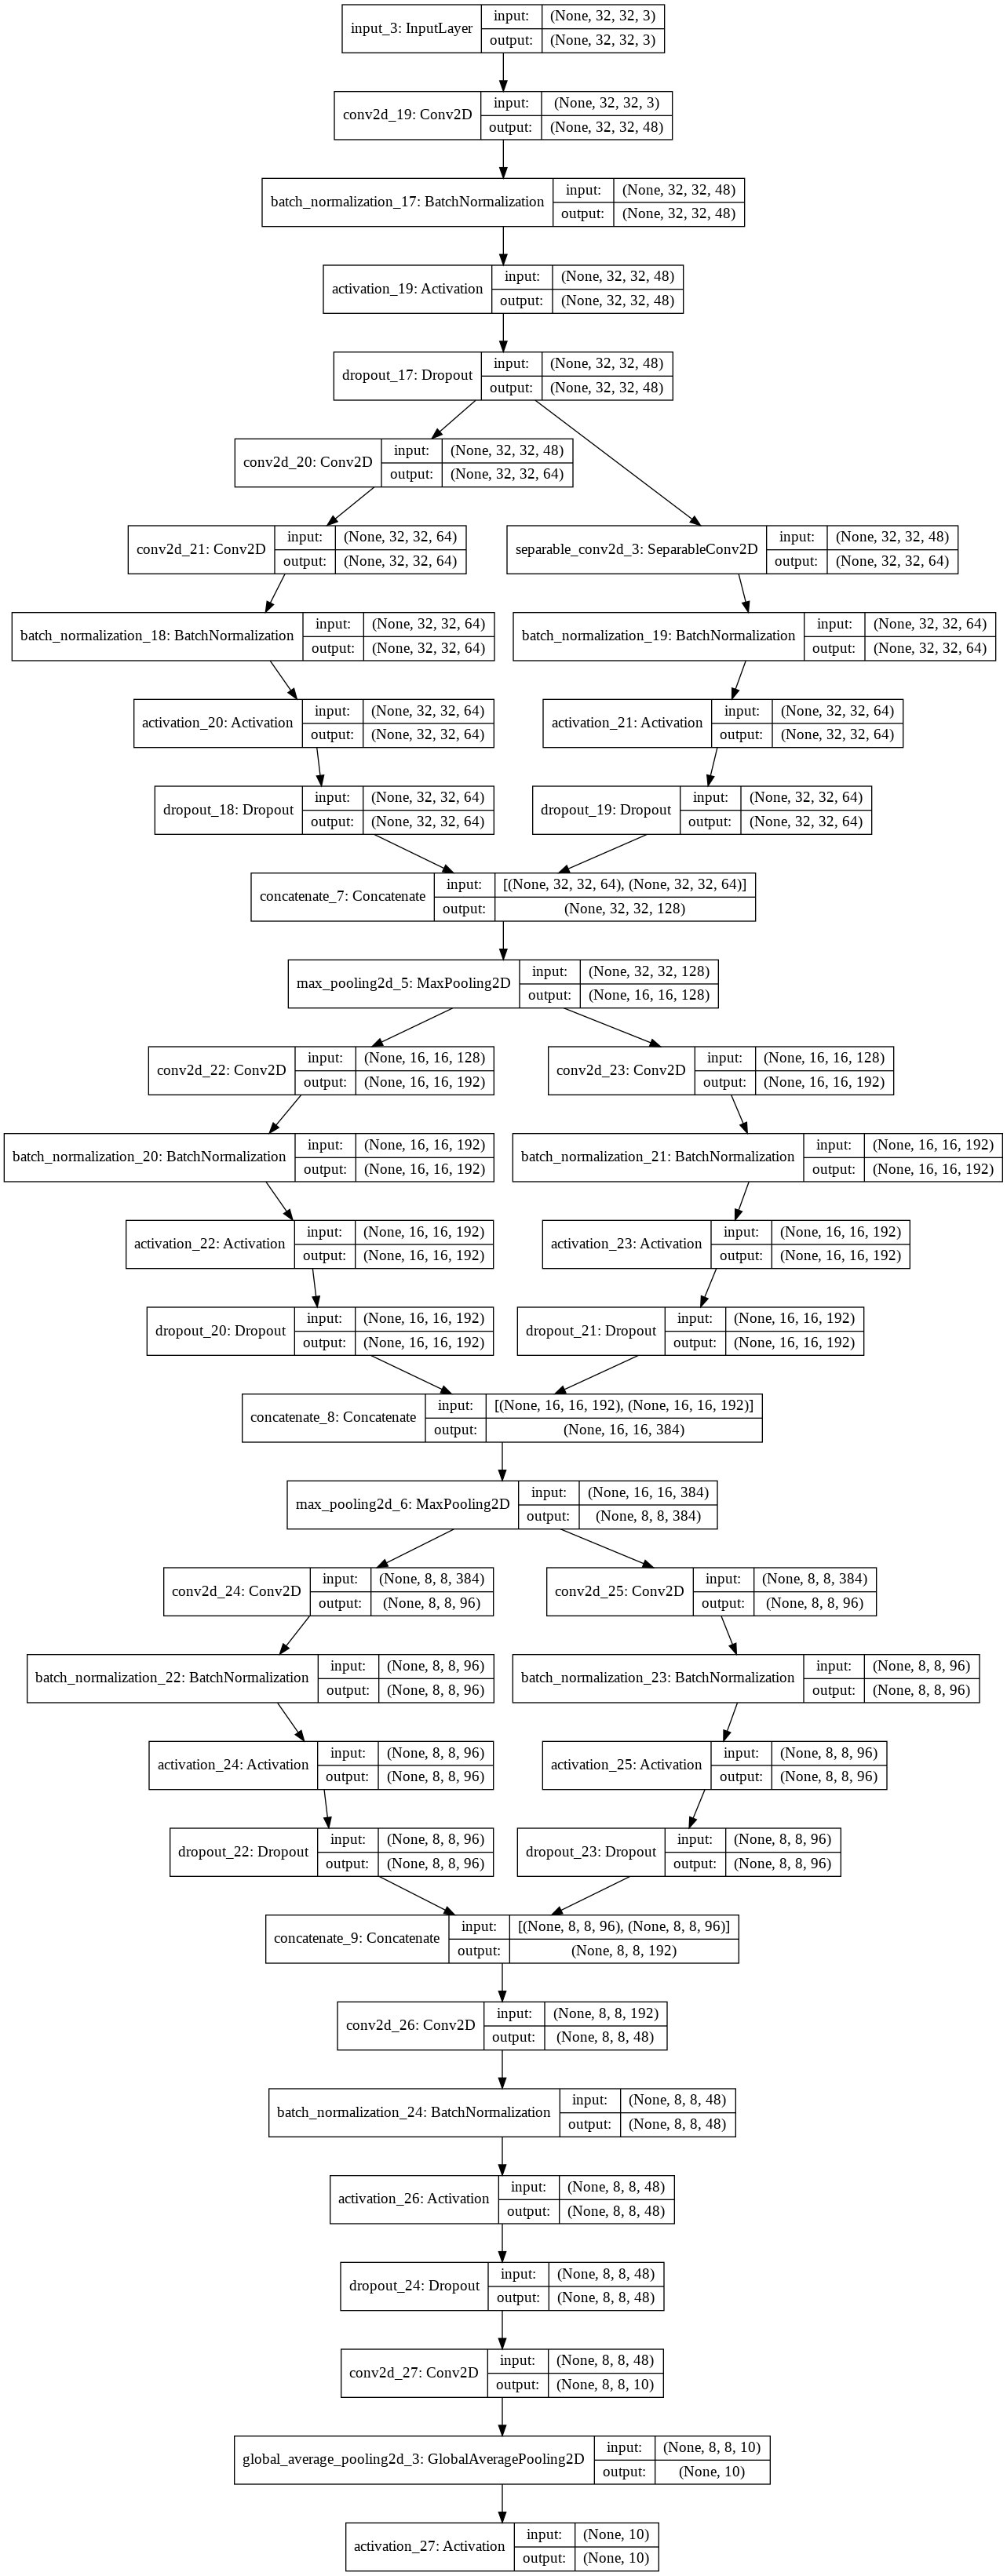

In [26]:
print(model.summary())
keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)


In [27]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

start=time.time()
train_datagen = ImageDataGenerator(featurewise_center = True, 
                                   featurewise_std_normalization = True,
                                   rotation_range = 10,
                                   zoom_range = 0.10,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1)
test_datagen = ImageDataGenerator(featurewise_center = True, featurewise_std_normalization = True)
train_datagen.fit(train_features)
test_datagen.fit(test_features)

train_data_iter = train_datagen.flow(train_features,train_labels, batch_size = 128)
test_data_iter =  test_datagen.flow(test_features,test_labels, batch_size = 10000)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

CKPT = ModelCheckpoint(filepath = 'best_model_6b.hdf5', monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)
model_info = model.fit_generator(train_data_iter,
                                 steps_per_epoch = 1000, nb_epoch = 50, 
                                 validation_data = test_data_iter.next(), verbose=1, callbacks = [CKPT])

end=time.time()




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=1000, validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., epochs=50)`


Epoch 1/50
1000/1000 [==============================] - 172s 172ms/step - loss: 1.0437 - acc: 0.6323 - val_loss: 1.1326 - val_acc: 0.6265

Epoch 00001: val_acc improved from -inf to 0.62650, saving model to best_model_6b.hdf5
Epoch 2/50
1000/1000 [==============================] - 167s 167ms/step - loss: 0.6429 - acc: 0.7762 - val_loss: 0.9716 - val_acc: 0.6758

Epoch 00002: val_acc improved from 0.62650 to 0.67580, saving model to best_model_6b.hdf5
Epoch 3/50
1000/1000 [==============================] - 166s 166ms/step - loss: 0.5000 - acc: 0.8257 - val_loss: 0.9721 - val_acc: 0.7120

Epoch 00003: val_acc improved from 0.67580 to 0.71200, saving model to best_model_6b.hdf5
Epoch 4/50
1000/1000 [==============================] - 166s 166ms/step - loss: 0.4077 - acc: 0.8577 - val_loss: 0.7835 - val_acc: 0.7491

Epoch 00004: val_acc improved from 0.71200 to 0.74910, saving model to best_model_6b.hdf5
Epoch 5/50
1000/1000 [==============================] - 166s 166ms/step - loss: 0.3358 

NameError: ignored

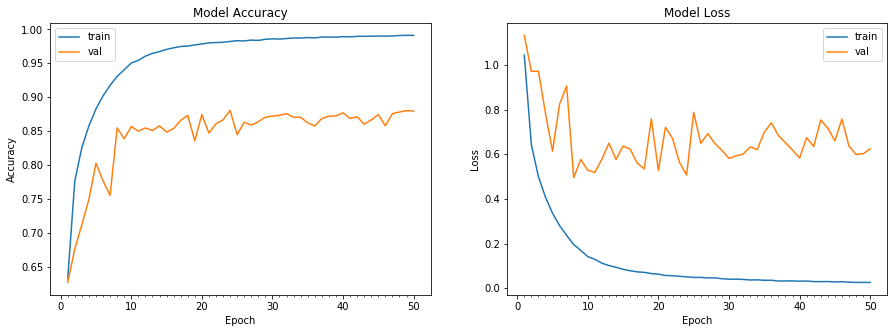

In [29]:
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)

In [30]:
# compute test accuracy
model.load_weights('./best_model_6b.hdf5')
test_features, test_labels = test_data_iter.next()
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Accuracy on test data is: 88.04
